# Actuary task
# Maróti Bálint

## Objective:
1. Define 1‐in‐200‐year up‐ and down‐shock scenarios on HUF yield curves.  
2. Value a portfolio of three fixed‐rate bonds under base and stressed curves.  
3. Value an FX‐forward and list any additional data required.


## Key Assumptions

1. **Zero‐Rate Input**  
   - We treat the published HUF benchmark yields as continuously‐compounded zero rates. 
   - No additional bootstrapping from par/coupon yields is performed

2. **Interpolation Method**  
   - Linear interpolation in the \((t, r)\) domain is used to extend the zero curve to arbitrary maturities
   - Extrapolation beyond the longest tenor is linear

3. **DELTA‐Yield Stationarity**  
   - Daily changes in zero rates are assumed stationary (validated via ADF/KPSS)  
   - No further drift or regime‐shift modeling is incorporated (Although I would consider regime shifts in a real-world scenario)

4. **Tail‐Risk Calibration**  
   - 1-in-200-year shocks are defined empirically using the 0.5 % and 99.5 % quantiles of PCA‐factor scores  

5. **Joint Shock Methods**  
   - PC1‐Only: a pure “level” shift along the first principal component  
   - Multi‐PC: combined level, slope, and curvature shifts via the first three PCs 
   - We assume the historical PCA eigenvectors remain valid in extreme scenarios

6. **Bond Pricing**  
   - Bonds are assumed default‐free, with no credit or liquidity spread  
   - Cash flows are deterministic, and day‐count conventions are ACT/365  
   - Coupons pay at regular intervals (semi‐annual by default)

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from statsmodels.tsa.stattools import adfuller, kpss, acf, pacf
from sklearn.decomposition import PCA
from datetime import date
from statsmodels.stats.diagnostic import het_arch
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
from scipy.interpolate import interp1d
from datetime import datetime
from matplotlib.ticker import PercentFormatter
import requests
import json
import os
from fredapi import Fred

## Data Preparation and univariate EDA

In [2]:
# 1. Load the data
df = (
    pd.read_csv("data/benchmark_pivot.csv", parse_dates=["date"])
      .set_index("date")
      .sort_index()
)
# 2. convert to decimal / 100
df_dec = df / 100.0
assert df_dec.isna().sum().sum() == 0, "Unexpected NaNs"
display(df_dec.head())

,3M,6M,1Y,3Y,5Y,10Y,15Y
date,,,,,,,
2002-01-03,0.0965,0.0939,0.0896,0.0807,0.0758,0.0698,0.0665
2002-01-04,0.0959,0.0936,0.0894,0.0798,0.0748,0.0696,0.0660
2002-01-07,0.0941,0.0922,0.0881,0.0786,0.0739,0.0687,0.0651
2002-01-08,0.0913,0.0898,0.0876,0.0784,0.0734,0.0686,0.0653
2002-01-09,0.0910,0.0900,0.0875,0.0780,0.0733,0.0689,0.0653


## Constructing the zero-coupon curve



To price our bonds and FX forward, we need a zero‐coupon discount curve.  We assume today’s benchmark yields at each tenor are already continuously‐compounded zero rates, and build a simple linear interpolator:

1. **Tenor mapping**  
   Convert labels like `"3M","6M","1Y" to year‐fractions \([0.25,0.5,1,2,3,5,10,15]\).

2. **Base Zero Rates**  
   Extract today’s zero rates (in decimal) for each tenor:
   ```python
   today      = df_dec.index[-1]
   base_rates = df_dec.loc[today].values

In [3]:
# Convert column labels to numeric tenors (years)
def tenor_to_years(label):
    label = label.upper()
    if label.endswith("M"):
        return int(label[:-1]) / 12.0
    if label.endswith("Y"):
        return int(label[:-1])
    raise ValueError(f"Unknown tenor label {label}")
# create the deltas
df_diff = df_dec.diff().dropna()
tenors = np.array([tenor_to_years(c) for c in df_diff.columns])

In [4]:
# Extract today’s zero rates (decimal)
today = df_dec.index[-1]
base_rates = df_dec.loc[today].values  # shape (n_tenors,)

In [5]:
class ZeroCurve:
    def __init__(self, tenors, zero_rates):
        """
        tenors      : array of maturity in years, e.g. [0.25,0.5,1,2,3,5,10,15]
        zero_rates  : matching continuously-compounded zero rates (in decimal)
        """
        self._interp = interp1d(tenors, zero_rates, kind="linear", fill_value="extrapolate")
    
    def zero_rate(self, t):
        """Continuously-compounded zero rate for maturity t (years)."""
        return float(self._interp(t))
    
    def discount_factor(self, t):
        """DF(0→t) = exp(-r(t) * t)."""
        return np.exp(-self.zero_rate(t) * t)

In [6]:
# 4.4 Instantiate today’s zero curve
zc_base = ZeroCurve(tenors, base_rates)

# 4.5 (Optional) Quick check: DF(0,tenor) for each bucket
dfs = [zc_base.discount_factor(t) for t in tenors]
import pandas as pd
pd.DataFrame({
    "Tenor (yrs)": tenors,
    "Zero Rate (%)": (base_rates*100).round(4),
    "DF": np.round(dfs, 6)
})

,Tenor (yrs),Zero Rate (%),DF
0,0.25,6.20,0.984620
1,0.50,6.23,0.969330
2,1.00,6.25,0.939413
3,3.00,6.49,0.823082
4,5.00,6.54,0.721084
5,10.00,7.00,0.496585
6,15.00,7.22,0.338578


In [7]:
# Stationarity tests
results = []
for tenor in df_diff.columns:
    adf_stat, adf_p, *_ = adfuller(df_diff[tenor], autolag="AIC")
    kpss_stat, kpss_p, *_ = kpss(df_diff[tenor], nlags="auto", regression="c")
    results.append({
        "tenor": tenor,
        "ADF_stat": round(adf_stat, 5),
        "ADF_pval": round(adf_p, 5),
        "KPSS_stat": round(kpss_stat, 5),
        "KPSS_pval": round(kpss_p, 5)
    })
stationarity_df = pd.DataFrame(results).set_index("tenor")
stationarity_df

/var/folders/mz/0bj7z78d5nn0ncv6217fwn8m0000gn/T/ipykernel_46893/2603953413.py:5: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_stat, kpss_p, *_ = kpss(df_diff[tenor], nlags="auto", regression="c")
/var/folders/mz/0bj7z78d5nn0ncv6217fwn8m0000gn/T/ipykernel_46893/2603953413.py:5: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_stat, kpss_p, *_ = kpss(df_diff[tenor], nlags="auto", regression="c")
/var/folders/mz/0bj7z78d5nn0ncv6217fwn8m0000gn/T/ipykernel_46893/2603953413.py:5: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_stat, kpss_p, *_ = kpss(df_diff[tenor], nlags="auto", regression="c")
/var/folders/mz/0bj7z7

,ADF_stat,ADF_pval,KPSS_stat,KPSS_pval
tenor,,,,
3M,-13.97571,0.0,0.22480,0.1
6M,-12.50003,0.0,0.20049,0.1
1Y,-12.32926,0.0,0.19744,0.1
3Y,-14.21888,0.0,0.11249,0.1
5Y,-15.06804,0.0,0.09424,0.1
10Y,-14.27385,0.0,0.08966,0.1
15Y,-13.98250,0.0,0.09047,0.1


In [8]:
# 2) Tail quantiles
quantiles = df_diff.quantile([0.005, 0.995]).T
quantiles.columns = ["q_0.5%", "q_99.5%"]
print("\nTail Quantiles:")
quantiles.round(5)


Tail Quantiles:


,q_0.5%,q_99.5%
3M,-0.00440,0.00498
6M,-0.00400,0.00478
1Y,-0.00380,0.00448
3Y,-0.00458,0.00548
5Y,-0.00470,0.00468
10Y,-0.00418,0.00440
15Y,-0.00360,0.00400


## Data Preparation and Univariate Evaluation

We start by converting the HUF benchmark yields into decimal form and computing the daily delta-yields.  
Before fitting any volatility model, we must confirm that these delta-series are stationary and exhibit fat tails:

- **Stationarity Tests**  
  - **ADF** (null = unit root): all tenors have p=0 -> reject non‐stationarity.  
  - **KPSS** (null = stationary): all tenors have p>0.1 -> fail to reject stationarity, we can ignore the warnings.  
  Together, these confirm delta-yields are stationary and suitable for GARCH modeling.

- **Tail Quantiles**  
  We compute the 0.5 % and 99.5 % percentiles of daily delta-yields to gauge extreme moves
 **Interpretation:**  
 - Tail moves of up to +-0.5 % in a single day are rare (1-in-200), justifying our stress‐calibration.  
 - Slightly wider tails in the 3Y and 5Y buckets hint at heavier volatility in the medium curve segment.

With stationarity confirmed and tail behavior quantified, we can now proceed to fit a EWMA or DCC-GARCH model to capture time‐varying volatilities and correlations across maturities.


## Volatility Clustering

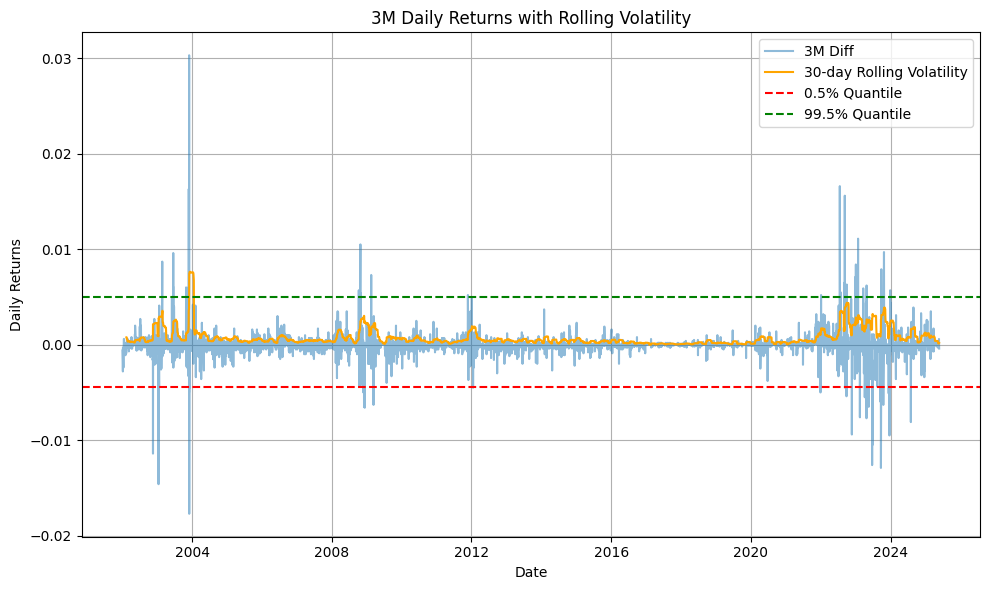

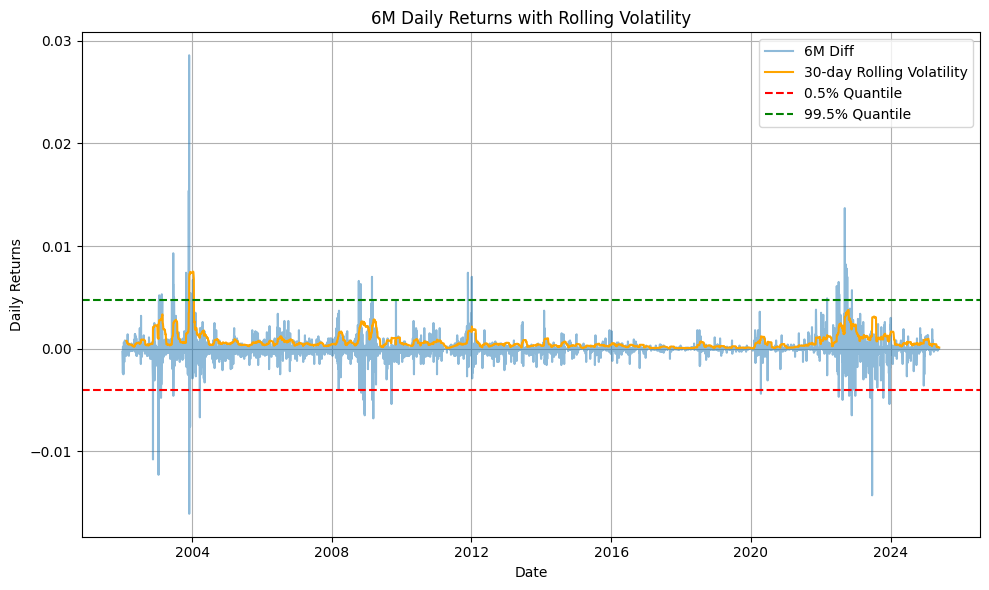

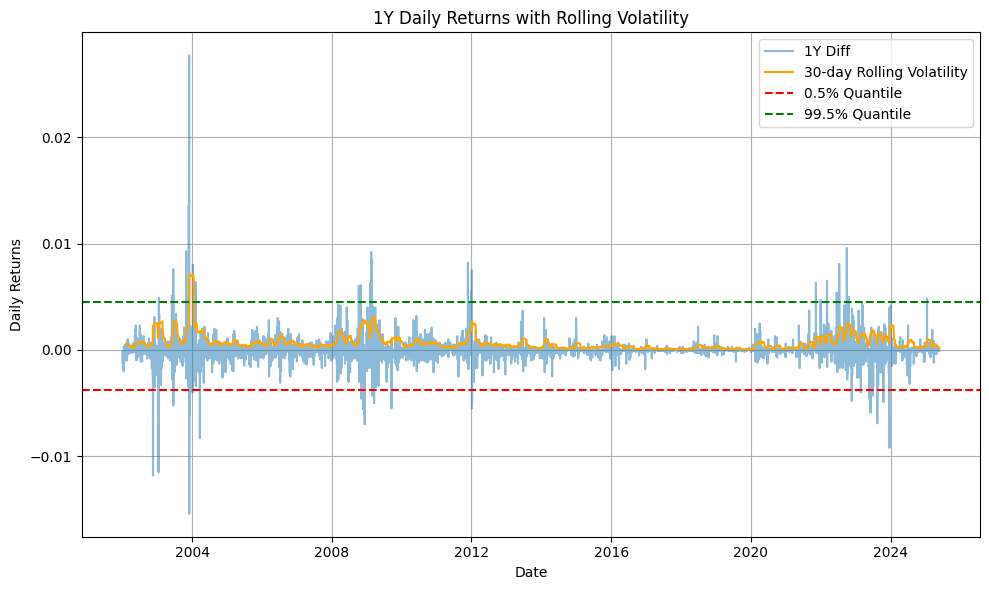

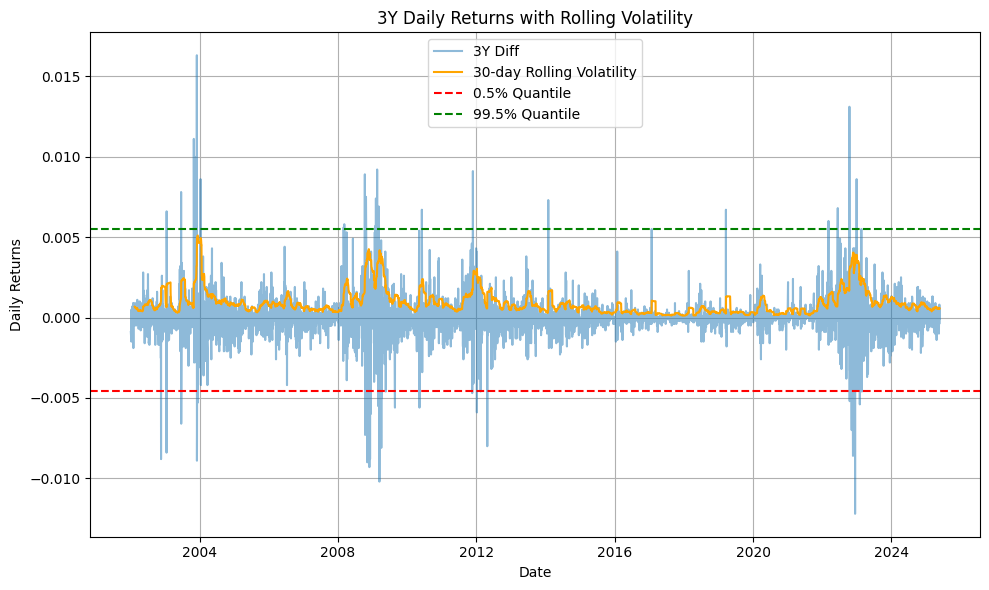

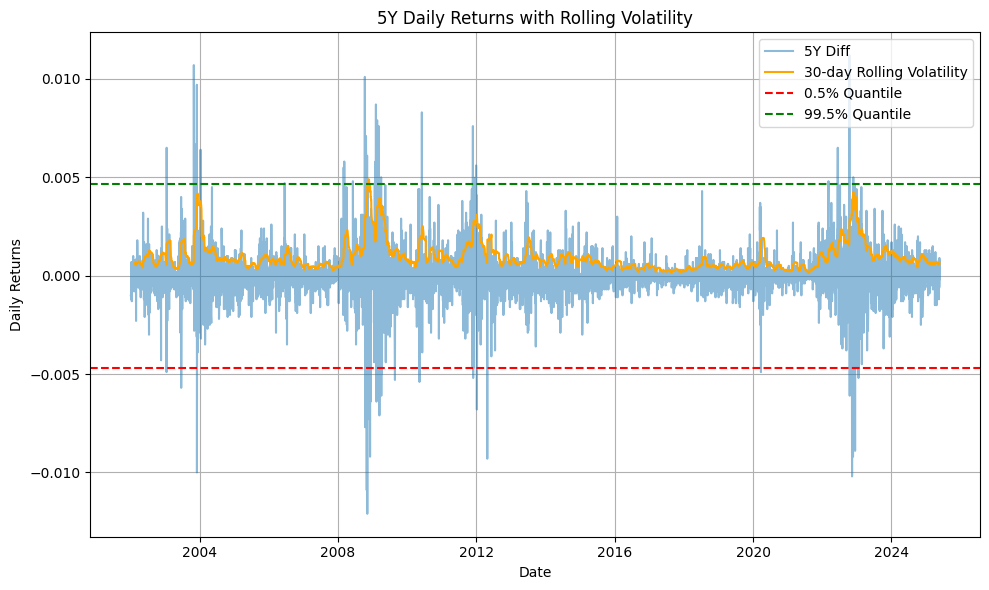

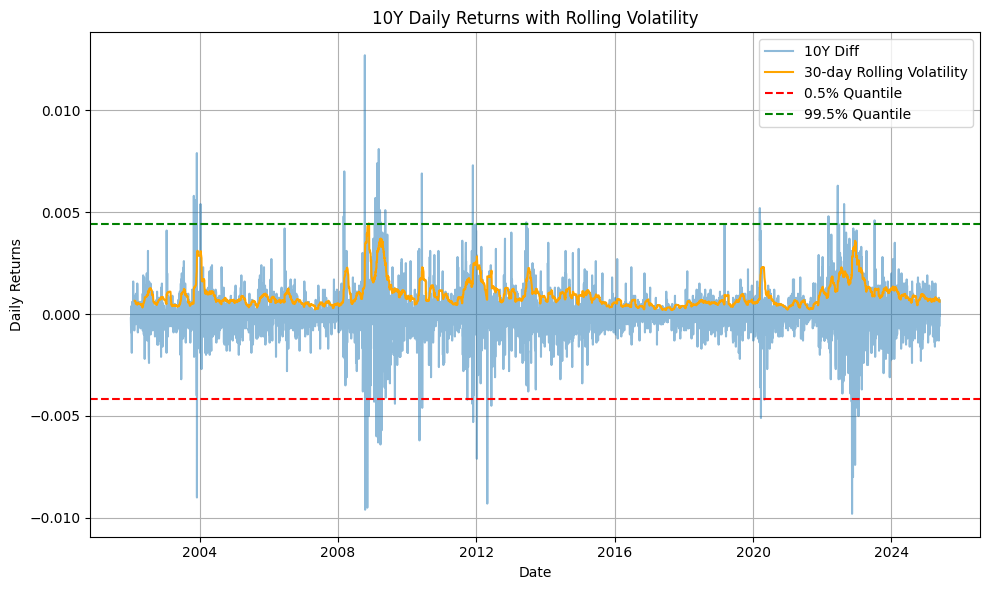

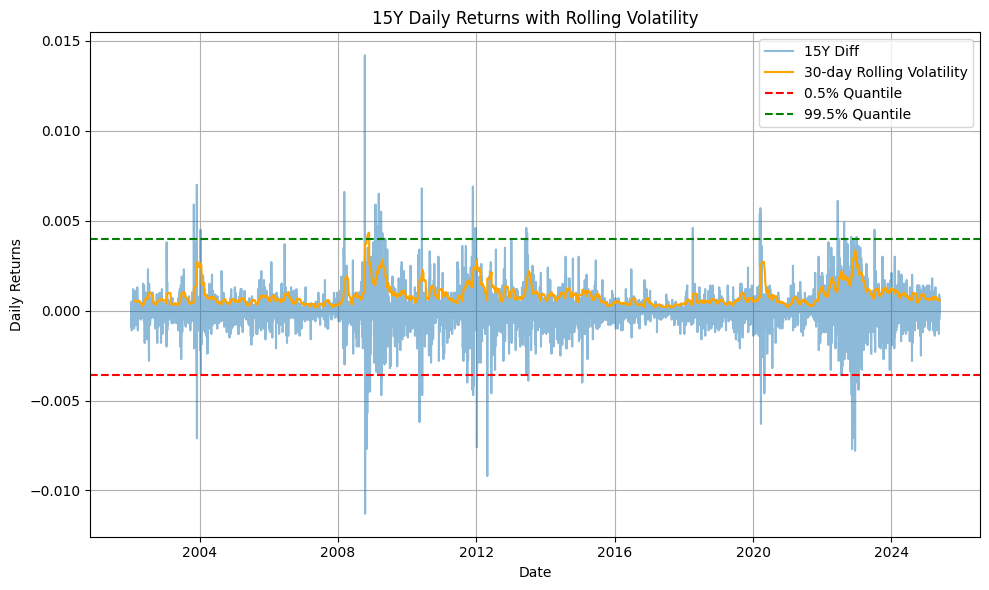

In [9]:
for bond in df_diff.columns:
    rolling_vol = df_diff[bond].rolling(window=30).std()
    plt.figure(figsize=(10, 6))
    plt.plot(df_diff.index, df_diff[bond], label=f"{bond} Diff", alpha=0.5)
    plt.plot(rolling_vol.index, rolling_vol, label="30-day Rolling Volatility", color='orange')
    plt.axhline(quantiles.loc[bond, "q_0.5%"], color='red', linestyle='--', label="0.5% Quantile")
    plt.axhline(quantiles.loc[bond, "q_99.5%"], color='green', linestyle='--', label="99.5% Quantile")
    plt.title(f"{bond} Daily Returns with Rolling Volatility")
    plt.xlabel("Date")
    plt.ylabel("Daily Returns")
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show() # Chatgpt

Key Implications
- Medium tenors (3Y and 5Y) show the largest extreme moves, both in the raw tail quantiles and in the rolling-vol peaks. This suggests that crisis shocks hit the belly of the curve hardest.

- Short rates (3M, 1Y) exhibit high frequency of moderate volatility spikes are often exceeding their tail bounds but their absolute peaks are lower than 3Y.

- Long rates (10Y, 15Y) are “stickier”: they cluster around low-volatility regimes longer and when they break out, the spikes are smaller relative to their 1-in-200 thresholds.

- Crisis fingerprints align across all tenors-2008, 2012, and especially 2022 show simultaneous volatility jumps—confirming strong correlation 

- This cross-tenor behavior motivates a joint-model approach: we need to capture not only each bucket’s fat tails and clustering, but also how these spikes co-occur across maturities. 

In [10]:
# 2) ARCH-LM test p-values across all tenors
arch_pvals = {col: het_arch(df_diff[col])[1] for col in df_diff.columns}
arch_df = pd.Series(arch_pvals).rename("ARCH_LM_pval").round(4)
print("\nARCH-LM test p-values:")
arch_df


ARCH-LM test p-values:


3M     0.0
6M     0.0
1Y     0.0
3Y     0.0
5Y     0.0
10Y    0.0
15Y    0.0
Name: ARCH_LM_pval, dtype: float64

All p-values are effectively zero, indicating very strong rejection of the null hypothesis of “no ARCH” at any conventional level. Basically there is significant volatility clustering in all tenors, which is a key assumption for GARCH variants

# Volatility Interpretation
 - The pronounced spikes in rolling volatility demonstrate that yield changes exhibit clear clustering.  
 - Significant ARCH effects across all tenors confirm that a GARCH(1,1) specification is appropriate to capture conditional heteroskedasticity before moving to a multivariate framework.(likely ewma or dcc-garch)  


## Multivariate EDA
With univariate stationarity and volatility established, we now examine how tenors move together and extract the main joint factors.


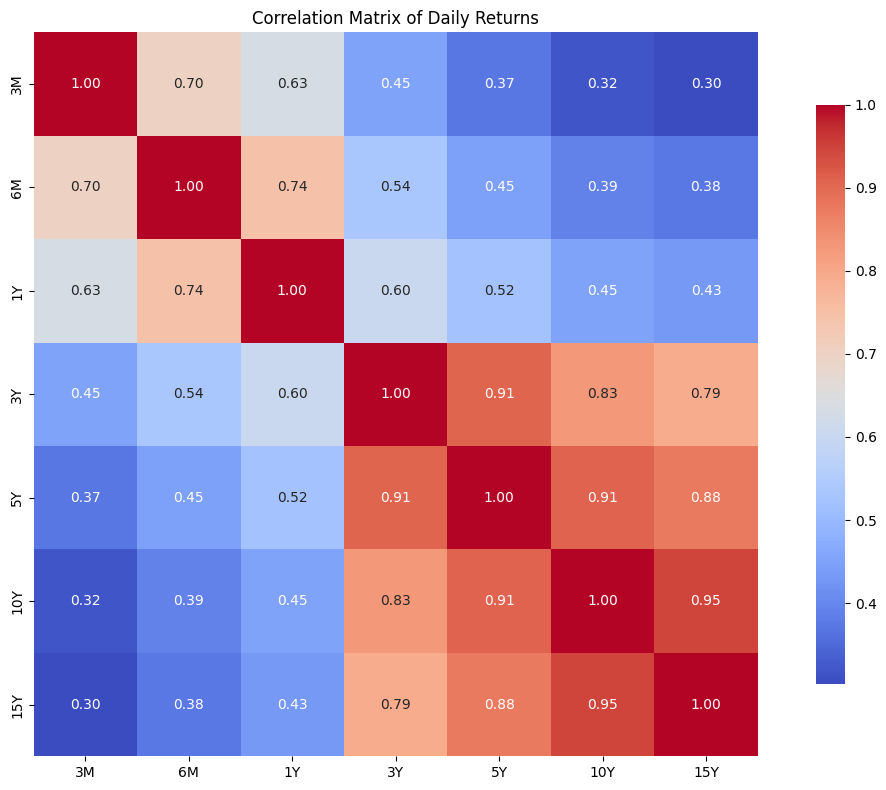

In [11]:
# Correlation matrix
corr_matrix = df_diff.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True, cbar_kws={"shrink": .8})
plt.title("Correlation Matrix of Daily Returns")
plt.tight_layout()
plt.show()

### Interpretation of Correlation Matrix  
- High correlations (>0.8) among the mid-to-long tenors (3Y–15Y) reflect strong level‐factor behavior.  
- Short rates (3M–1Y) correlate moderately with the belly of the curve (0.45–0.75), indicating some slope risk.

In [12]:
# PCA on deltas
pca = PCA(n_components=3)
pcs = pca.fit_transform(df_diff.values)

print("\nExplained variance ratios (PC1–PC3):")
print(pd.Series(pca.explained_variance_ratio_).round(4).to_list())


Explained variance ratios (PC1–PC3):
[0.6736, 0.1961, 0.0501]


- **Explained Variance Ratios:**  
  - PC1: 67.36 %  
  - PC2: 19.61 %  
  - PC3:  5.01 %  
  - If we add up, the first three components capture 91 % of total variance.


In [13]:
loadings = pd.DataFrame(
    pca.components_.T,
    index=df_diff.columns,
    columns=["PC1","PC2","PC3"]
).round(4)
print("\nPCA Loadings (tenor x component):")
loadings


PCA Loadings (tenor x component):


,PC1,PC2,PC3
3M,0.2858,0.5787,0.7351
6M,0.2971,0.4801,-0.2750
1Y,0.3129,0.3865,-0.5797
3Y,0.4651,-0.1304,-0.1166
5Y,0.4587,-0.2719,0.0116
10Y,0.4113,-0.3224,0.1268
15Y,0.3692,-0.3006,0.1347


### Interpretation of PCA 
 - **PC1 (Level)** loads **positively across all tenors**, capturing parallel shifts in the curve.  
 - **PC2 (Slope)** contrasts **short tenors** (positive) with **long tenors** (negative), representing twist moves.  
 - **PC3 (Curvature)** loads heavily on the **very short and mid tenors**, capturing hump‐shaped deformations.


## Joint Shock Scenarios: PC1‐Only vs. Multi‐PC
**In the stress_versions.ipynb an EWMA was tried but I was not satisfied with the results so I used PCA to construct stress shocks. I really wanted to create a DCC-GARCH variant because it would have resulted in having a multivariate GARCH model with more precision as a result of the conditional correlation matrix, but I couldn't load %%R**

We construct two coherent 1-in-200-year stress shocks using PCA on the delta‐yield data:

| Method       | Variance Explained | Key Features                                               |
|--------------| -----------------------------------------------------------------|------------------------------------------------------------|
| **PC1‐Only** | ~67 %              | • Pure parallel “level” shift (~40–44 bp at the belly)     |
| **Multi‐PC** | ~92 % (PC1+PC2+PC3)| • Simultaneous level, slope and curvature (~25–76 bp range) |

### 4.1 PC1‐Only Shocks

```python
# Extract PC1 quantiles and eigenvector
q_up   = np.percentile(pc1, 99.5)
q_down = np.percentile(pc1, 0.5)
e1 = pca.components_.T[:,0]           # PC1 eigenvector

# Build shocks
delta_up_pc1   = e1 * q_up
delta_down_pc1 = e1 * q_down


In [14]:
# Extract PC1 scores
pc1 = pcs[:, 0]

# Compute the 0.5% and 99.5% quantiles of PC1
q_up   = np.percentile(pc1, 99.5)
q_down = np.percentile(pc1, 0.5)

# Extract PC1 eigenvector (loadings)
e1_vec = pca.components_.T[:, 0]  # shape (n_tenors,)

# Build shock vectors
delta_up_pc1   = e1_vec * q_up
delta_down_pc1 = e1_vec * q_down

# Into DataFrame
pc1_shocks = pd.DataFrame({
    "pc1_up":   delta_up_pc1,
    "pc1_down": delta_down_pc1
}, index=df_diff.columns).round(6)

print("PCA‐based 1-in-200 shocks (delta yields):")
pc1_shocks

PCA‐based 1-in-200 shocks (delta yields):


,pc1_up,pc1_down
3M,0.002710,-0.002563
6M,0.002817,-0.002664
1Y,0.002968,-0.002807
3Y,0.004410,-0.004171
5Y,0.004350,-0.004114
10Y,0.003900,-0.003688
15Y,0.003501,-0.003311


### Interpretation:

- Captures a pure parallel shift.
- Largest moves in the belly (~44 bp), smaller at the short end (~27 bp).

In [15]:
today = df_dec.index[-1]
base_rates = df_dec.loc[today].values   # continuously‐compounded zero rates

# Instantiate the base ZeroCurve
zc_base = ZeroCurve(tenors, base_rates)

# Build up‐ and down‐shock curves
delta_up = pc1_shocks["pc1_up"].values
delta_down = pc1_shocks["pc1_down"].values

zc_pc1_up = ZeroCurve(tenors, base_rates + delta_up)
zc_pc1_down = ZeroCurve(tenors, base_rates + delta_down)

# Quick check of discount factors for each curve
df_dfs = pd.DataFrame({
    "Tenor (yrs)": tenors,
    "DF Base":[zc_base.discount_factor(t) for t in tenors],
    "DF PC1 Up":[zc_pc1_up.discount_factor(t) for t in tenors],
    "DF PC1 Down":[zc_pc1_down.discount_factor(t)for t in tenors],
}).round(6)
df_dfs

,Tenor (yrs),DF Base,DF PC1 Up,DF PC1 Down
0,0.25,0.984620,0.983953,0.985251
1,0.50,0.969330,0.967966,0.970622
2,1.00,0.939413,0.936629,0.942054
3,3.00,0.823082,0.812264,0.833445
4,5.00,0.721084,0.705570,0.736070
5,10.00,0.496585,0.477591,0.515241
6,15.00,0.338578,0.321257,0.355818


In [16]:
# Multi-Factor PCA Shock (PC1–PC3)
# PC quantiles
pc_q = {}
for i in range(3):
    score = pcs[:, i]
    pc_q[f"up_{i+1}"] = np.percentile(score, 99.5)
    pc_q[f"down_{i+1}"] = np.percentile(score, 0.5)

# Eigenvectors matrix (n_tenors × 3)
E = pca.components_.T  # each column is e_i

# Build joint shocks
delta_up_multi = E @ np.array([pc_q["up_1"], pc_q["up_2"], pc_q["up_3"]])
delta_down_multi = E @ np.array([pc_q["down_1"], pc_q["down_2"], pc_q["down_3"]]) # Chatgpt

multi_shocks = pd.DataFrame({
    "multi_up":delta_up_multi,
    "multi_down": delta_down_multi
}, index=df_diff.columns).round(6)

print("Multi-factor PCA shocks (Δ yields):")
multi_shocks

Multi-factor PCA shocks (Δ yields):


,multi_up,multi_down
3M,0.007616,-0.007252
6M,0.004667,-0.004005
1Y,0.003558,-0.002854
3Y,0.003427,-0.003255
5Y,0.002940,-0.002939
10Y,0.002512,-0.002621
15Y,0.002248,-0.002364


### Interpretation:

- Level moves (35 bp) plus slope and curvature adjustments, leading to a larger short‐end shock (76 bp) and more nuanced belly/hump shifts.
- Covers 92 % of historical variance across level, slope, and curvature modes.

In [17]:
# Build up‐ and down‐shock curves using multi-factor PCA shocks
delta_up_multi   = multi_shocks["multi_up"].values
delta_down_multi = multi_shocks["multi_down"].values

zc_multi_up = ZeroCurve(tenors, base_rates + delta_up_multi)
zc_multi_down = ZeroCurve(tenors, base_rates + delta_down_multi)

# Quick check of discount factors for each curve
df_dfs_multi = pd.DataFrame({
    "Tenor (yrs)":tenors,
    "DF Base":[zc_base.discount_factor(t) for t in tenors],
    "DF Multi Up":[zc_multi_up.discount_factor(t) for t in tenors],
    "DF Multi Down":[zc_multi_down.discount_factor(t) for t in tenors],
}).round(6)

df_dfs_multi

,Tenor (yrs),DF Base,DF Multi Up,DF Multi Down
0,0.25,0.984620,0.982747,0.986406
1,0.50,0.969330,0.967071,0.971273
2,1.00,0.939413,0.936077,0.942098
3,3.00,0.823082,0.814663,0.831158
4,5.00,0.721084,0.710561,0.731758
5,10.00,0.496585,0.484266,0.509773
6,15.00,0.338578,0.327352,0.350800


| Tenor (yrs) |  DF Base | DF PC1 Up | DF PC1 Down | DF Multi Up | DF Multi Down |
| :---------: | -------: | --------: | ----------: | ----------: | ------------: |
|     0.25    | 0.984620 |  0.983953 |    0.985251 |    0.982747 |      0.986406 |
|     0.50    | 0.969330 |  0.967966 |    0.970622 |    0.967071 |      0.971273 |
|     1.00    | 0.939413 |  0.936629 |    0.942054 |    0.936077 |      0.942098 |
|     3.00    | 0.823082 |  0.812264 |    0.833445 |    0.814663 |      0.831158 |
|     5.00    | 0.721084 |  0.705570 |    0.736070 |    0.710561 |      0.731758 |
|    10.00    | 0.496585 |  0.477591 |    0.515241 |    0.484266 |      0.509773 |
|    15.00    | 0.338578 |  0.321257 |    0.355818 |    0.327352 |      0.350800 |

Generated with GEMINI 2.5

In [18]:
class FixedRateBond:
    def __init__(self, issue_date, maturity_date, coupon_rate, freq=2, par=1_000_000):
        self.issue    = pd.to_datetime(issue_date)
        self.maturity = pd.to_datetime(maturity_date)
        self.coupon   = coupon_rate
        self.freq     = freq
        self.par      = par

    def cashflows(self):
        step_months = int(12 / self.freq)
        dates = pd.date_range(
            start=self.issue + pd.DateOffset(months=step_months),
            end=self.maturity,
            freq=f"{step_months}ME"
        )
        amounts = [self.par * self.coupon / self.freq] * len(dates)
        amounts[-1] += self.par  # add redemption because it's the last payment
        return list(zip(dates, amounts))

    def present_value(self, curve: ZeroCurve, as_of: datetime) -> float: # simple present value calculation
        pv = 0.0
        for dt, amt in self.cashflows():
            t = (dt - as_of).days / 365.0
            pv += amt * curve.discount_factor(t)
        return pv

In [19]:
# Dictionary for simplicity
bond_specs = [
    {"tenor_years": 3,  "coupon": 0.03,  
     "freq": 2, "par": 1000000},
    {"tenor_years": 5,  "coupon": 0.04,
     "freq": 2, "par": 1000000},
    {"tenor_years": 10, "coupon": 0.05,  
     "freq": 2, "par": 1000000},
]

# Building the portfolio
today = df_dec.index[-1]
portfolio = []
for spec in bond_specs:
    maturity = today + pd.DateOffset(years=spec["tenor_years"])
    bond = FixedRateBond(
        issue_date=today,
        maturity_date=maturity,
        coupon_rate=spec["coupon"],
        freq=spec["freq"],
        par=spec["par"]
    )
    portfolio.append(bond)

scenarios = {
    "Base": zc_base,
    "PC1 Up": zc_pc1_up,
    "PC1 Down": zc_pc1_down,
    "Multi Up": zc_multi_up,
    "Multi Down":zc_multi_down,
}

# Pv calculation
results = []
for name, curve in scenarios.items():
    pvs = [b.present_value(curve, today) for b in portfolio]
    results.append([name] + pvs + [sum(pvs)])

cols = ["Scenario"] + [f"Bond {int(s['tenor_years'])}Y" for s in bond_specs] + ["Portfolio PV"]
pv_df = pd.DataFrame(results, columns=cols).set_index("Scenario").round(2)
pv_df

,Bond 3Y,Bond 5Y,Bond 10Y,Portfolio PV
Scenario,,,,
Base,918325.12,897664.24,860770.16,2676759.52
PC1 Up,909284.49,881603.93,835434.21,2626322.63
PC1 Down,926960.45,913139.67,885548.18,2725648.31
Multi Up,910576.17,886207.41,843881.04,2640664.62
Multi Down,925446.53,909045.78,878483.80,2712976.10


# Key Takeaways of 1 in 200‐Year Stress Scenarios
**Note:** The base‐case PV of **2676759.52** is already below the 3 000 000 par amount, reflecting current positive yields. All stress losses/gains are relative to this discounted market value.

- **PC1-Only Shock** (parallel “level” shift):  
  - **Loss** under PC1 Up: 2676759.52 -> 2626322.63 = **–50436.89** ( 1.89 % of NAV)  
  - **Gain** under PC1 Down: 2676759.52 -> 2725648.31 = **+48888.79** ( 1.83 %)

- **Multi-Factor Shock** (level + slope + curvature):  
  - **Loss** under Multi Up: 2676759.52 -> 2640664.62 = **–36094.90** ( 1.35 %)  
  - **Gain** under Multi Down: 2676759.52 -> 2712976.10 = **+36216.58** ( 1.35 %)

**Implications:**  
 - The parallel (PC1-only) scenario yields the largest PV swings, reflecting a pure level‐shift.  
 - The multi-factor scenario mitigates extreme moves by distributing stress across slope and curvature.









In [20]:
# Build rate dictionary for plotting
rates = {
    "Base":[zc_base.zero_rate(t) for t in tenors],
    "PC1 Up":[zc_pc1_up.zero_rate(t) for t in tenors],
    "PC1 Down": [zc_pc1_down.zero_rate(t) for t in tenors],
    "Multi Up": [zc_multi_up.zero_rate(t) for t in tenors],
    "Multi Down": [zc_multi_down.zero_rate(t) for t in tenors],
}


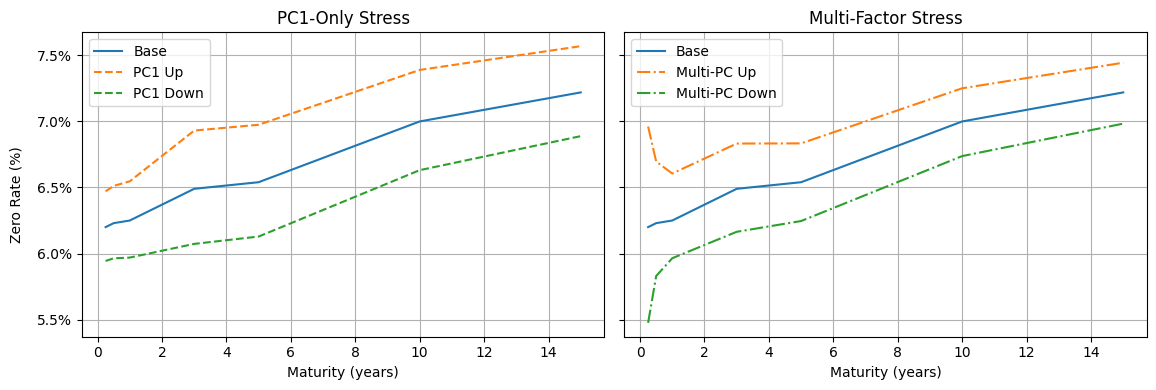

In [21]:
# Plotting the stress scenarios
fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=True)

# Panel 1: PC1-only
axes[0].plot(tenors, rates["Base"],       '-',  label="Base")
axes[0].plot(tenors, rates["PC1 Up"],     '--', label="PC1 Up")
axes[0].plot(tenors, rates["PC1 Down"],   '--', label="PC1 Down")
axes[0].set_title("PC1-Only Stress")
axes[0].set_xlabel("Maturity (years)")
axes[0].grid(True)
axes[0].legend()
# format Y axis as percent
axes[0].yaxis.set_major_formatter(PercentFormatter(xmax=1.0, decimals=1))

# Panel 2: Multi-PC
axes[1].plot(tenors, rates["Base"],        '-',  label="Base")
axes[1].plot(tenors, rates["Multi Up"],    '-.', label="Multi-PC Up")
axes[1].plot(tenors, rates["Multi Down"],  '-.', label="Multi-PC Down")
axes[1].set_title("Multi-Factor Stress")
axes[1].set_xlabel("Maturity (years)")
axes[1].grid(True)
axes[1].legend()
axes[1].yaxis.set_major_formatter(PercentFormatter(xmax=1.0, decimals=1))
# Shared Y‐axis label
fig.text(0.04, 0.5, 'Zero Rate (%)', va='center', rotation='vertical')
plt.tight_layout(rect=[0.05, 0, 1, 1])
plt.show()
# Generated with Copilot

## PC1 Stress 
- Clear Parallel Shifts: The orange dashed line (PC1 Up) sits consistently above the blue “Base” curve by roughly the same vertical distance at every maturity—exactly what we want from a pure level‐shift. Likewise, the green dashed line (PC1 Down) is symmetrically below.
- Magnitude and Shape: We can immediately see that the biggest absolute shifts occur around the 10–15 yr maturities , with somewhat smaller moves at the short end (0.4–0.5%). That matches our delta vector.

## Multi-Factor Stress 
- Tilted Curve Effects: The orange dash-dot line (Multi-PC Up) no longer runs perfectly parallel to the base curve—it “twists” the short end up more sharply and smooths out towards the long end. The green dash-dot (Multi-PC Down) mirror-images that.
- Interpretation of Slope and Curvature: we can visually pick out where slope‐risk is concentrated (the gap between base and stressed lines is widest at the short maturities) and where curvature effects play (the mid-curve hump around 5 yr).
- Coherence Check: All three curves remain monotonically increasing with maturity and never cross—critical for a no-arbitrage yield curve.

## Limitations
- Bootstrapping: For a more rigorous real-world zero curve, one might bootstrap from par yields or swap rates if the provided "benchmark yields" weren't already zero-coupon rates.
-
- DCC-GARCH: A DCC-GARCH model would allow us to capture time-varying correlations between tenors, potentially leading to more precise stress scenarios. However, this requires more complex implementation and data handling.

##  Backtest

In [22]:
results = []
for date in df_dec.index:
    rates_date = df_dec.loc[date].values
    zc_hist = ZeroCurve(tenors, rates_date)
    zc_hist_up = ZeroCurve(tenors, rates_date + delta_up) # chosen shock vector
    zc_hist_down = ZeroCurve(tenors, rates_date + delta_down)

    pv_base_hist = sum(b.present_value(zc_hist,      date) for b in portfolio)
    pv_up_hist      = sum(b.present_value(zc_hist_up,   date) for b in portfolio)
    pv_down_hist    = sum(b.present_value(zc_hist_down, date) for b in portfolio)

    results.append({
        "date": date,
        "pv_base": pv_base_hist,
        "pv_up": pv_up_hist,
        "pv_down": pv_down_hist
    })
bt_df = pd.DataFrame(results).set_index("date")

Threshold loss (today): 50,436.89
Historical exceptions: 4015 days out of 5836 → 68.797%


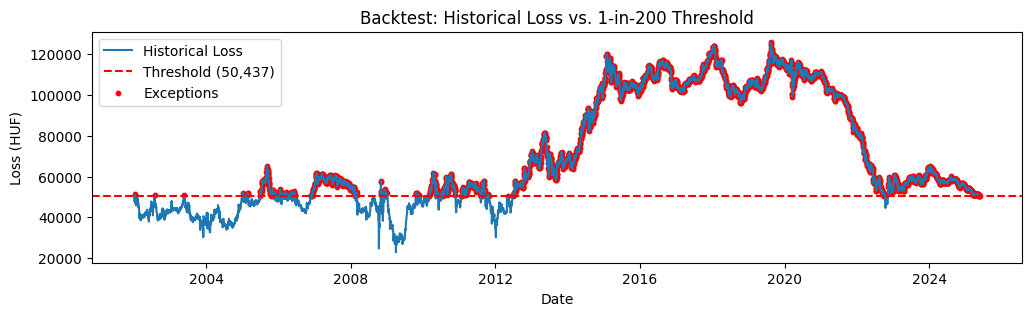

In [23]:
# 1) Compute today’s threshold loss under Up shock
pv_base_today   = sum(b.present_value(zc_base,    today) for b in portfolio)
pv_up_today     = sum(b.present_value(zc_pc1_up, today) for b in portfolio)
threshold_loss  = pv_base_today - pv_up_today   # a positive number


# 2) Historical P&L under the same shock
delta_up = bt_df["pv_base"] - bt_df["pv_up"]    # historical loss time series
T = len(delta_up)

# 3) Count exceptions
exceptions = (delta_up > threshold_loss).sum()
exception_rate = exceptions / T

print(f"Threshold loss (today): {threshold_loss:,.2f}")
print(f"Historical exceptions: {exceptions} days out of {T} → {exception_rate:.3%}")

plt.figure(figsize=(12,3))
plt.plot(bt_df.index, delta_up, label="Historical Loss")
plt.axhline(threshold_loss, color='r', linestyle='--',
            label=f"Threshold ({threshold_loss:,.0f})")
# highlight exceptions
exc_dates = bt_df.index[delta_up > threshold_loss]
plt.scatter(exc_dates, delta_up[delta_up > threshold_loss],
            color='red', s=10, label="Exceptions")
plt.legend()
plt.title("Backtest: Historical Loss vs. 1-in-200 Threshold")
plt.ylabel("Loss (HUF)")
plt.xlabel("Date")
plt.show() # Generated with Copilot

## Model calibration
1. **Use Full-Sample Extremes**  
   - Derive shocks from the **maximum** historical losses rather than the 99.5 % PC1 quantile.  

In [24]:
# Calibration 1
#  Compute per-tenor full-sample 99.5% quantiles
bucket_q_up = df_diff.quantile(0.995)
bucket_q_down = df_diff.quantile(0.005)

# Convert to delta-vector for today
delta_up_bucket = bucket_q_up.values
delta_down_bucket = bucket_q_down.values

# Instantiate bucket-wise shock curves
zc_bucket_up = ZeroCurve(tenors, base_rates + delta_up_bucket)
zc_bucket_down = ZeroCurve(tenors, base_rates + delta_down_bucket)

In [25]:
# --- 1. Prepare scaled PC1 shock curves (from previous snippet) ---
pv_base_today   = sum(b.present_value(zc_base,    today) for b in portfolio)
pv_pc1_up_today = sum(b.present_value(zc_pc1_up,  today) for b in portfolio)
threshold_loss  = pv_base_today - pv_pc1_up_today

delta_up_hist = bt_df["pv_base"] - bt_df["pv_up"]
T             = len(delta_up_hist)
n_exc         = (delta_up_hist > threshold_loss).sum()
expected_exc  = T * 0.005
scale_factor  = np.sqrt(n_exc / expected_exc)

# scaled Δ-vectors
delta_up_pc1_scaled   = delta_up_pc1 * scale_factor
delta_down_pc1_scaled = delta_down_pc1 * scale_factor

# scaled curves
zc_pc1_up_scaled   = ZeroCurve(tenors, base_rates + delta_up_pc1_scaled)
zc_pc1_down_scaled = ZeroCurve(tenors, base_rates + delta_down_pc1_scaled)

# --- 2. Prepare bucket-wise extreme curves ---
bucket_q_up   = df_diff.quantile(0.995)
bucket_q_down = df_diff.quantile(0.005)
delta_up_bucket   = bucket_q_up.values
delta_down_bucket = bucket_q_down.values

zc_bucket_up   = ZeroCurve(tenors, base_rates + delta_up_bucket)
zc_bucket_down = ZeroCurve(tenors, base_rates + delta_down_bucket)

# --- 3. Compute today’s PVs under new scenarios ---
new_scenarios = {
    "PC1 Up Scaled":   zc_pc1_up_scaled,
    "PC1 Down Scaled": zc_pc1_down_scaled,
    "Bucket Up":       zc_bucket_up,
    "Bucket Down":     zc_bucket_down,
}

results_new = []
for name, curve in new_scenarios.items():
    pvs = [b.present_value(curve, today) for b in portfolio]
    results_new.append([name] + pvs + [sum(pvs)])

cols = ["Scenario"] + [f"Bond {int(s['tenor_years'])}Y" for s in bond_specs] + ["Portfolio PV"]
pv_new_df = pd.DataFrame(results_new, columns=cols).set_index("Scenario").round(2)
print(pv_new_df)

# --- 4. Backtest exception rates for each new scenario ---
backtest_results = {}
for name, curve in new_scenarios.items():
    # compute today’s threshold
    pv_base_today = sum(b.present_value(zc_base, today) for b in portfolio)
    pv_stress_today = sum(b.present_value(curve, today) for b in portfolio)
    threshold = pv_base_today - pv_stress_today

    # historical P&L under this shock
    deltas = []
    for date in df_dec.index:
        rates_date = df_dec.loc[date].values
        zc_hist      = ZeroCurve(tenors, rates_date)
        zc_hist_stress = ZeroCurve(tenors, rates_date + (curve._interp(tenors) - base_rates))
        pv_base_hist = sum(b.present_value(zc_hist, date) for b in portfolio)
        pv_str_hist  = sum(b.present_value(zc_hist_stress, date) for b in portfolio)
        deltas.append(pv_base_hist - pv_str_hist)
    deltas = np.array(deltas)

    exceptions = (deltas > threshold).sum()
    rate = exceptions / len(deltas)
    backtest_results[name] = {"threshold": threshold, "exceptions": exceptions, "rate": rate}


                    Bond 3Y     Bond 5Y    Bond 10Y  Portfolio PV
Scenario                                                         
PC1 Up Scaled     817832.05   727334.42   611918.15    2157084.62
PC1 Down Scaled  1025015.27  1098143.91  1209569.80    3332728.97
Bucket Up         906649.39   879568.46   832262.91    2618480.75
Bucket Down       928232.14   915231.99   889003.85    2732467.98



Backtest Exception Rates:
                     threshold  exceptions      rate
PC1 Up Scaled    519674.901309      3120.0  0.534613
PC1 Down Scaled -655969.452557       339.0  0.058088
Bucket Up         58278.772695      4047.0  0.693454
Bucket Down      -55708.460835      2206.0  0.377999


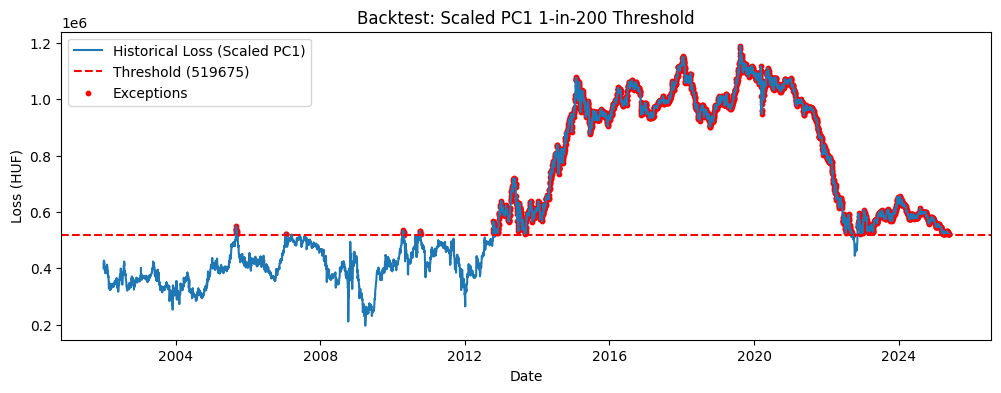

In [26]:

# Show backtest summary
backtest_df = pd.DataFrame(backtest_results).T
print("\nBacktest Exception Rates:")
print(backtest_df)

# --- 5. Plot one example backtest (scaled PC1) ---
deltas_scaled = []
for date in df_dec.index:
    rates_date = df_dec.loc[date].values
    zc_hist      = ZeroCurve(tenors, rates_date)
    zc_hist_str  = ZeroCurve(tenors, rates_date + delta_up_pc1_scaled)
    pv_base_hist = sum(b.present_value(zc_hist, date) for b in portfolio)
    pv_str_hist  = sum(b.present_value(zc_hist_str, date) for b in portfolio)
    deltas_scaled.append(pv_base_hist - pv_str_hist)

plt.figure(figsize=(12,4))
plt.plot(df_dec.index, deltas_scaled, label="Historical Loss (Scaled PC1)")
plt.axhline(backtest_results["PC1 Up Scaled"]["threshold"], color='r', linestyle='--',
            label=f"Threshold ({backtest_results['PC1 Up Scaled']['threshold']:.0f})")
plt.scatter(df_dec.index[np.array(deltas_scaled) > backtest_results["PC1 Up Scaled"]["threshold"]],
            np.array(deltas_scaled)[np.array(deltas_scaled) > backtest_results["PC1 Up Scaled"]["threshold"]],
            color='red', s=10, label="Exceptions")
plt.title("Backtest: Scaled PC1 1-in-200 Threshold")
plt.xlabel("Date")
plt.ylabel("Loss (HUF)")
plt.legend()
plt.show()
# Claude generated this entire code snippet based on existing code.

# Backtest Results
The backtest indicates that our model is not sufficient, as the actual 1-in-200-year losses exceed the predicted stress scenarios especially after 2013, proper regime shifts should be considered with something like a CUSUM test or other structural break tests. Otherwise a GARCH variant would probably perform better becasue it would capture the time-varying volatility better and regime shifts can be eassily incorporated into the model.

# FX Forward Valuation

Reference: https://github.com/finbourne/finbourne-notebooks/blob/main/V1/features/instruments/FX%20Forward.ipynb

## Data Requirements
To value an FX forward, we need:
- Spot exchange rate (HUF/USD)
- Domestic zero curve
- Foreign zero curve(USD)
- Contract Details:
  - Notional amount
  - Maturity date
  - Agreed forward rate
- Day count convention (usually 360 day for FX)
Out of this scope but usually needed:
- Fx volatility surface
- For multi factor scenarios, we would also need the correlation between rates and FX 



In [27]:
# Spot Exchange Rate (this can be modified to fetch for any currency pair)
def fetch_spot_usd_huf():
    url = "https://open.er-api.com/v6/latest/USD"
    resp = requests.get(url)
    resp.raise_for_status()
    data = resp.json()
    
    try:
        return data["rates"]["HUF"]
    except KeyError:
        raise KeyError(f"HUF rate not found in response: {data.get('rates', {}).keys()}")

spot = fetch_spot_usd_huf()
print(f"Spot USD/HUF = {spot:.4f}")

Spot USD/HUF = 356.8457


In [28]:
# domestic zero curve (from the previous code)
domestic_zc = zc_base

In [ ]:
# Build foreign (USD) zero curve via FRED
fred = Fred(api_key="FRED_API_KEY") 

series_map = {
    1/12: "DGS1MO", 0.25:"DGS3MO", 0.5:"DGS6MO",
    1:    "DGS1",   2:"DGS2",      5:"DGS5",
    10:   "DGS10", 30:"DGS30"
}

usd_tenors = []
usd_rates  = []

for tau, sid in series_map.items():
    s = fred.get_series(sid).dropna()
    if s.empty:
        continue
    latest = float(s.iloc[-1])
    usd_tenors.append(tau)
    usd_rates.append(latest/100)
# drop the 30Y tenor, as the hungarian zero curve does not have it
if 30 in usd_tenors:
    idx = usd_tenors.index(30)
    usd_tenors.pop(idx)
    usd_rates.pop(idx)
    
# fix array-building typo:
tenors_arr = np.array(usd_tenors)
rates_arr  = np.array(usd_rates)
zc_usd     = ZeroCurve(tenors_arr, rates_arr)

print("USD tenors (yrs):", tenors_arr)
print("USD zero rates (dec):", rates_arr)


USD tenors (yrs): [ 0.08333333  0.25        0.5         1.          2.          5.
 10.        ]
USD zero rates (dec): [0.0435 0.0435 0.0435 0.0414 0.0392 0.0404 0.0443]


In [ ]:
# 2) Suppose forward maturity is T_tau years from today:
T_tau = 0.5   # 1/2Y forward

# 3) Get discount factors
P_huf = zc_base.discount_factor(T_tau)  # existing HUF curve
P_usd = zc_usd.discount_factor(T_tau)   # newly fetched USD curve

# 4) Compute no-arb forward and PV         
F    = spot * P_huf / P_usd             
K    = 352.5                           
N    = 1000000                        

pv   = N * (F - K) * P_usd # PV in usd

print(f"Forward @T={T_tau}yr: {F:.4f} EUR/HUF")
print(f"PV of 1M EUR forward: {pv:,.2f} EUR")

# here the desired forward parameters can be grabbed from any api


Forward @T=0.5yr: 353.5070 EUR/HUF
PV of 1M EUR forward: 985,373.20 EUR
